# MMDテンプレの処理フロー（①〜⑦：全体像）

前提：
- 列名で選択したい場合、df_train_raw / df_test_raw は pandas の DataFrame であること
  （NumPy配列なら列名は使えないので、列番号で選ぶか DataFrame に変換する）

(NumPy配列→DataFrameにしたい場合の形)
- df_train_raw = pd.DataFrame(df_train_normal, columns=[...列名...])
- df_test_raw  = pd.DataFrame(df_test_mix,    columns=[...列名...])

────────────────────────────────────────────────────────────

① データ読み込み
- TRAIN_INPUT / TEST_INPUT を読み込んで df_train_raw / df_test_raw を作る
- TIME_COL（任意）, LABEL_COL（任意：例 '__label__'）を決める

② 可視化（任意）
- 数値列をまとめて時系列プロット（異常ラベルがあれば背景色分け）

③ 周期性の確認（任意）
- Welchスペクトル + 自己相関 で「周期っぽいか」を見る
- 周期がありそうなら周期長 CYCLE_LEN の候補を得る

③’ 1サンプルの定義を決める（重要）
- SAMPLE_MODE を選ぶ（どれを “1行=1サンプル” にするか）
  - "as_is"      : 行=時刻点のまま（N×M）
  - "cycle_raw"  : 1周期をベクトル化（1行=1周期）
  - "cycle_fft"  : 1周期を周波数特徴にして1行（位相ズレに比較的強い）
  - "window_raw" : 固定窓をベクトル化（周期が無い/不明の代替）

③’’ 特徴量（使う列）を決める（重要）
- FEATURE_COLS を列名のリストで指定（ここに “入力特徴” だけを書く）
  例）FEATURE_COLS = ["Current", "Pressure", "Voltage", ...]
- ラベル列（例 'anomaly','changepoint','__label__'）は「特徴量に入れない」ことを推奨
  ※入れると “答え” を特徴として渡すことになり、検知が歪む

④ 学習/テストの入力行列を作る
- まず列名で抽出して DataFrame を作る
  - X_train_df = df_train_raw[FEATURE_COLS].copy()
  - X_test_df  = df_test_raw[FEATURE_COLS].copy()
- （必要なら）数値化 + 欠損補間
  - apply(to_numeric, errors="coerce") → interpolate(...)

- ③’で決めた SAMPLE_MODE に応じて、
  X_train_df / X_test_df を「周期・窓」単位の行列（2次元）に作り直す
  （cycle_raw / cycle_fft / window_raw を選んだとき）

⑤ 標準化（任意だが推奨）
- StandardScaler を train に fit → train/test に transform
  - X_train_std = scaler.fit_transform(X_train_df.values)
  - X_test_std  = scaler.transform(X_test_df.values)

⑥ MMDモデル構築（MMDDriftOnline）
- 参照分布 x_ref を train 先頭から作る（n_ref = min(N_REF, len(train))）
- window_size（直近何サンプルで比較するか）, ert（誤報を抑える調整）などを設定
- cd = MMDDriftOnline(x_ref, window_size=..., ert=..., n_bootstraps=..., backend=...)

⑦ ストリーム評価（train確認 → test本番）
- for i in range(n):
    out = cd.predict(x_t, return_test_stat=True)
  を回してログ化（mmd2 / threshold / is_drift）
- ログをプロットして、いつからスコアが上がるか（閾値超え）を見る
- ラベルがあるなら label 別に平均スコアなどで要約する



In [11]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from scipy.signal import detrend, welch
from statsmodels.tsa.stattools import acf

from alibi_detect.cd import MMDDriftOnline

## ① データ読み込み（必要最低限の説明）

目的：  
TRAIN_INPUT / TEST_INPUT から CSV を読み込み、`df_train_raw` と `df_test_raw`（pandas DataFrame）を作る。

入力の指定：
- `TRAIN_INPUT`, `TEST_INPUT`
  - CSVファイルでも、CSVが複数あるフォルダでもよい
  - フォルダ指定の場合は「直下の *.csv を全部読み、行方向に結合（縦に連結）」する

読み込みの仕様：
- `CSV_SEP`
  - None の場合：区切り文字を推定するため `engine="python"` を使う（遅いが柔軟）
  - 文字（"," 等）を指定した場合：`engine="c"` に切り替えて高速に読む
- `ENC_CANDIDATES`
  - 文字コードを上から順に試し、読めたものを採用する
- 読めた後に「列名の前後空白を削る」ので、列名の表記ゆれ（空白）を減らせる

関数の役割：
- `read_csv_easy(path)`
  - CSV 1ファイルを「文字コード候補を順に試しながら」読み込む
  - 成功したら DataFrame を返す（失敗し続けたら例外）
- `load_input(input_path)`
  - input がファイルなら `read_csv_easy` で読む
  - input がフォルダなら、直下の CSV を全部読み込んで `pd.concat(..., ignore_index=True)` で結合する

出力：
- `df_train_raw`, `df_test_raw`
  - どちらも DataFrame
  - `print(shape)` で行数・列数を確認できる

注意：
- `TIME_COL` / `LABEL_COL` の存在チェックは省略している（間違えない前提）。
  後工程で使う直前に `assert TIME_COL in df.columns` のように確認するのが安全。


In [12]:
# ============================================================
# ① データの読み込み：ユーザー設定
# ============================================================
TRAIN_INPUT = r".\data\\test_8\\train.csv"   # 入力：CSVファイル or CSV群が入ったフォルダ
TEST_INPUT  = r".\data\\test_8\\test.csv"

CSV_SEP = None  # 区切り文字。Noneなら区切り推定（ただし python engine を使うので遅め）
ENC_CANDIDATES = ["utf-8-sig", "utf-8", "cp932", "shift_jis"]  # 文字コード候補（上から順に試す）

TIME_COL  = "t"       # 時刻列の名前（このブロックでは使わない想定。後工程で使う）
LABEL_COL = "segment"  # ラベル列の名前（このブロックでは使わない想定。後工程で使う）




# ============================================================
# ① 実装（読み込み処理）
# ============================================================
def read_csv_easy(path: Path, sep=CSV_SEP, enc_candidates=ENC_CANDIDATES) -> pd.DataFrame:
    """
    目的：
      - CSVを「壊れにくく」読み込み、DataFrame を返す。
      - 文字コードが不明でも ENC_CANDIDATES を順に試して成功したものを採用する。

    入力：
      - path: 読み込むCSVファイルのパス
      - sep : 区切り文字（Noneなら推定）
      - enc_candidates: 試す文字コード候補のリスト

    処理：
      1) sep が None の場合は区切り推定が必要になるため、engine="python" を使う
         （pandasのCエンジンだと推定ができない/不安定な場合がある）
      2) enc_candidates を先頭から順に試し、読めた時点で返す
      3) 列名の前後空白を削除して「列名ミス」を減らす（" Voltage" などの事故防止）

    出力：
      - df: 読み込んだ DataFrame
    """
    # sep=None のときは「区切り推定」を期待するので python engine にする
    # sepが明示されているなら C engine の方が高速なので切り替える
    engine = "python" if sep is None else "c"

    # 文字コード候補を上から順に試す
    for enc in enc_candidates:
        try:
            df = pd.read_csv(path, sep=sep, engine=engine, encoding=enc)

            # 列名の前後空白を削る（例：" Voltage" → "Voltage"）
            df.columns = df.columns.astype(str).str.strip()
            return df
        except Exception:
            # この候補で読めなかったら次へ
            continue

    # 全て失敗した場合は例外（原因は「文字コード」「壊れたCSV」「区切り」「引用符」などが多い）
    raise RuntimeError(f"CSVが読めません: {path}")


def load_input(input_path, sep=CSV_SEP, enc_candidates=ENC_CANDIDATES) -> pd.DataFrame:
    """
    目的：
      - 入力が「ファイル」か「フォルダ」かに応じて読み込み方を切り替え、
        最終的に 1つの DataFrame にして返す。

    入力：
      - input_path: ファイルパス または フォルダパス
      - sep / enc_candidates: read_csv_easy に渡す設定

    処理：
      - input_path がファイルなら：その1ファイルを読んで返す
      - input_path がフォルダなら：
          1) 直下の *.csv を列挙（サブフォルダは見ない）
          2) 各CSVを読み込む
          3) 行方向に結合（縦に連結）して返す
        ※ この想定は「同じ列構成のCSVが複数ある」ケース（実験ログ分割など）向け

    出力：
      - df: 読み込み結果の DataFrame（フォルダ入力なら concat 後の1つの表）
    """
    p = Path(input_path)

    # 入力がファイルの場合：そのまま読む
    if p.is_file():
        return read_csv_easy(p, sep=sep, enc_candidates=enc_candidates)

    # 入力がフォルダの場合：直下のCSVを全部読んで縦に結合
    if p.is_dir():
        files = sorted(p.glob("*.csv"))  # 直下のみ。必要なら rglob に変更可能

        # generator で1つずつ読む（リスト化しないのでメモリに優しい）
        dfs = (read_csv_easy(f, sep=sep, enc_candidates=enc_candidates) for f in files)

        # ignore_index=True：元CSVのindexを捨てて 0..N-1 に振り直す（連結後の扱いが楽）
        return pd.concat(dfs, ignore_index=True)

    # どちらでもない（存在しない/パスが間違い）場合
    raise RuntimeError(f"存在しません: {p}")


# ============================================================
# 実行：train/test を読み込んで DataFrame を作る
# ============================================================
df_train_raw = load_input(TRAIN_INPUT)
df_test_raw  = load_input(TEST_INPUT)

# 全行0のsegment列を追加（int型）
df_train_raw["segment"] = 0

# 読めたかどうか（行数×列数）を確認
print("df_train_raw:", df_train_raw.shape)
print("df_test_raw :", df_test_raw.shape)



# NOTE:
# - ここでは TIME_COL / LABEL_COL の存在チェックは省略している
#   （ユーザーが「間違えない前提」としたため）
# - 後工程（特徴量抽出やラベル参照）で TIME_COL / LABEL_COL を使うなら、
#   その直前で df.columns に含まれることを assert するのが安全


df_train_raw: (50000, 7)
df_test_raw : (150000, 7)


## ② 可視化コードの使い方（コピペ用）

### 1) まず設定する（図サイズとフォント）
- FIG_W  : 図の横幅（インチ）
- ROW_H  : 1サブプロットあたりの高さ（インチ）→ 列が多いほど図が縦に伸びる
- FONT_SIZE : 基本フォント
- TITLE_SIZE: 各サブプロットのタイトル
- LABEL_SIZE: x軸ラベル
- TICK_SIZE : 目盛り

例（見やすく大きめ）：
- FIG_W=14, ROW_H=2.5, FONT_SIZE=12, TITLE_SIZE=13, LABEL_SIZE=12, TICK_SIZE=11

### 2) 対象列を作る
- 数値列だけを自動抽出する：
  ALL_FEATURE_CANDIDATES = get_numeric_feature_candidates(df_train_raw)

### 3) 描画する
- train と test で同じ列リストを使う（比較しやすい）

例：
plot_timeseries_simple(df_train_raw, ALL_FEATURE_CANDIDATES,
    title="TRAIN", time_col=None, label_col="__label__", n=5000,
    fig_w=12, row_h=2.8, font_size=11, title_size=12, label_size=11, tick_size=10)

plot_timeseries_simple(df_test_raw, ALL_FEATURE_CANDIDATES,
    title="TEST", time_col=None, label_col="__label__", n=5000,
    fig_w=12, row_h=2.8, font_size=11, title_size=12, label_size=11, tick_size=10)

### 4) よく使う調整
- 列が多すぎて縦長になる → max_cols を指定（例：max_cols=20）
- もっと大きい図にしたい → FIG_W や ROW_H を増やす
- 文字が小さい → FONT_SIZE / TITLE_SIZE / TICK_SIZE を増やす

注意：
- label_col を None にすると背景色分けは無効になる
- time_col を None にすると x軸は行番号（0,1,2,...）になる


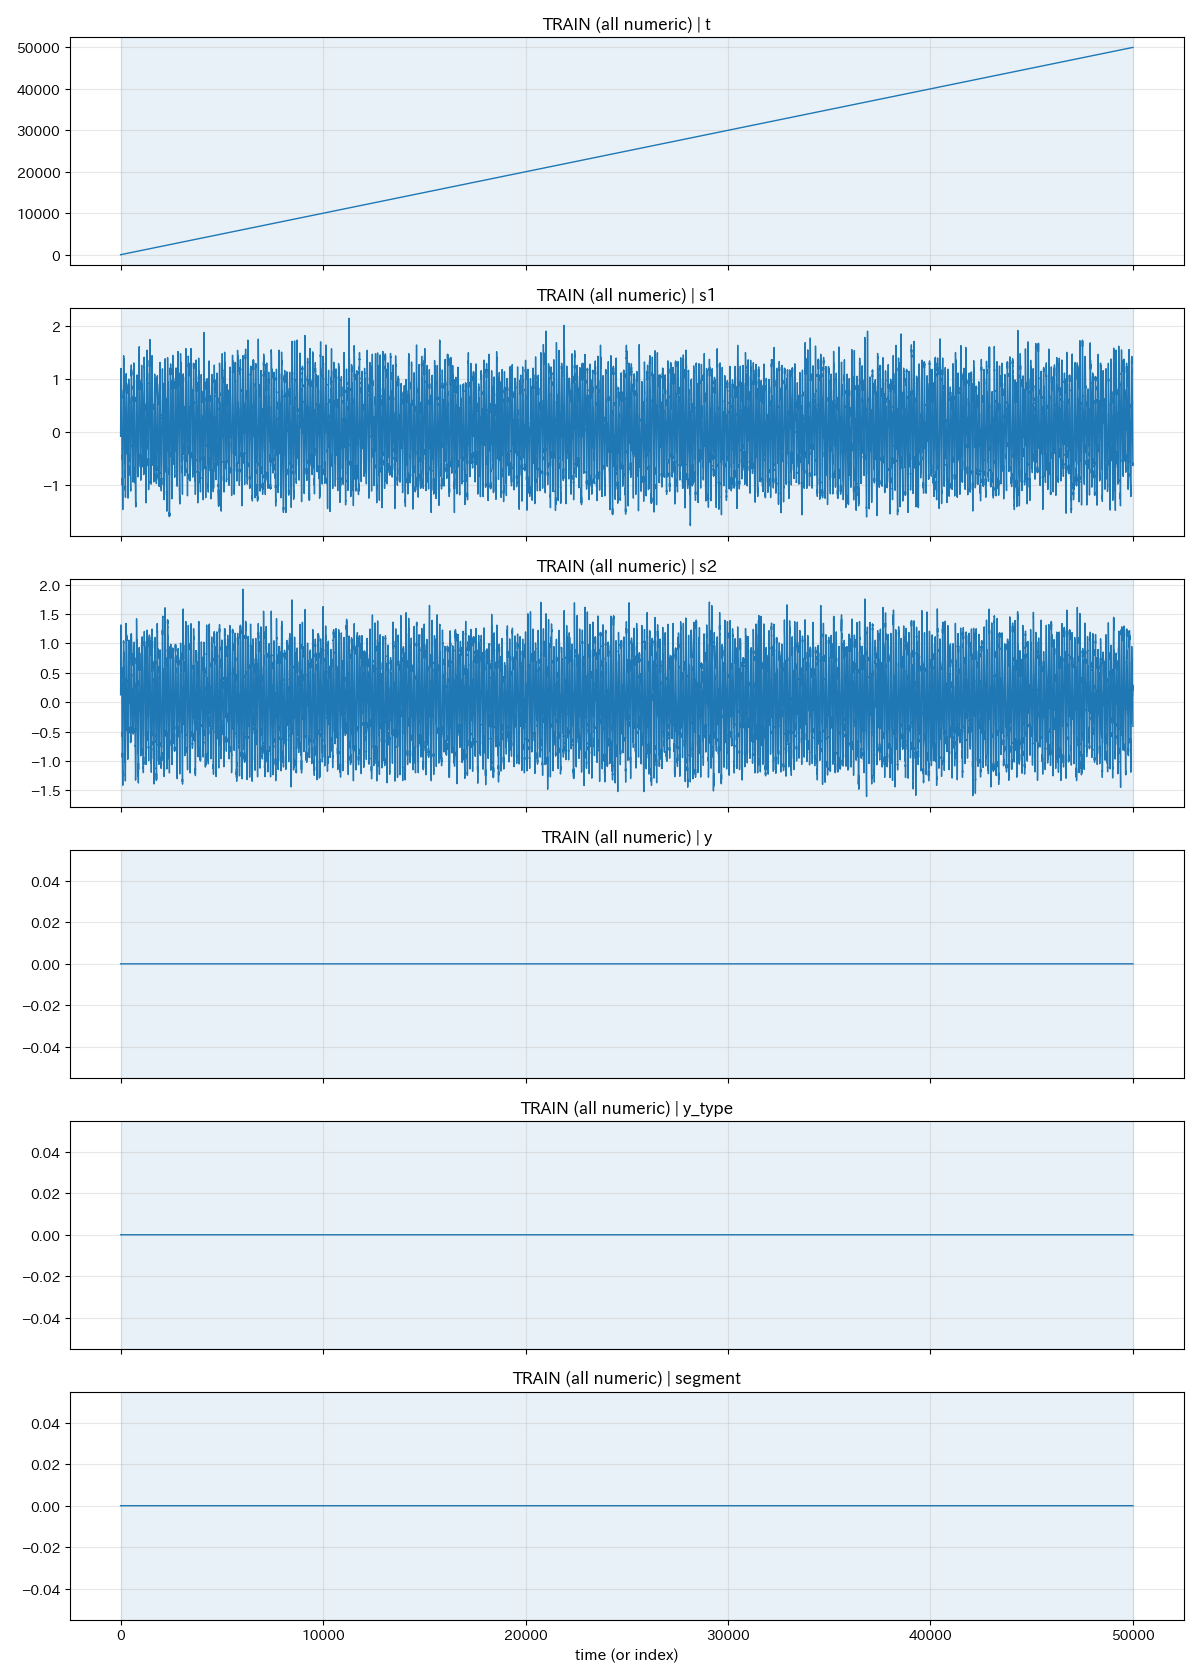

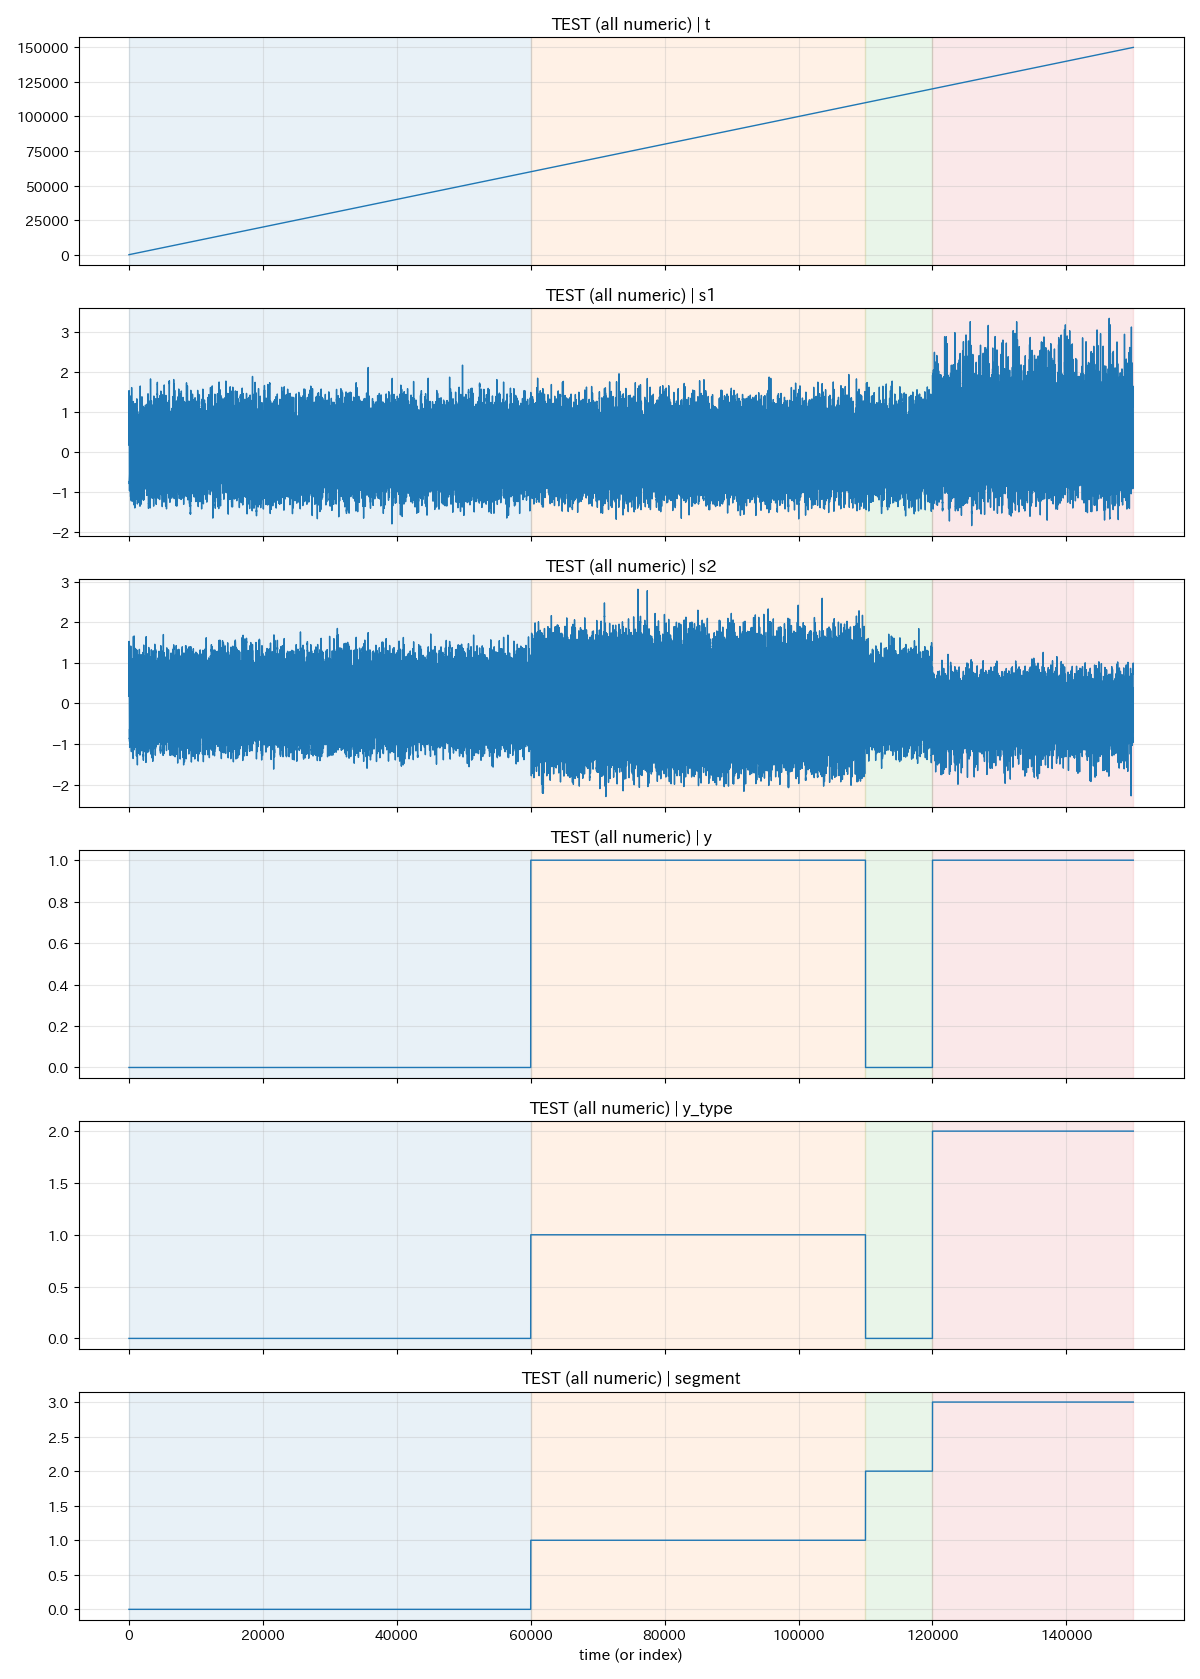

In [13]:
# ============================================================
# ② 可視化：ユーザー設定
# ============================================================
PLOT_N    = df_test_raw.shape[0]   # プロットする行数の上限
#TIME_COL  = None                  # 例: "time" / 無ければ None
#LABEL_COL = "__label__"           # 無ければ None（背景色分けしない）

# 追加：図サイズ・フォントサイズ設定
FIG_W  = 12.0      # 図の横幅（インチ）
ROW_H  = 2.8       # 1列（1サブプロット）あたりの高さ（インチ）
FONT_SIZE = 11     # 基本フォントサイズ
TITLE_SIZE = 12    # タイトル（各サブプロット）のフォントサイズ
LABEL_SIZE = 11    # 軸ラベルのフォントサイズ
TICK_SIZE  = 10    # 目盛りのフォントサイズ


# ============================================================
# ② すべての「数値列」を対象にする（除外なし）
# ============================================================
def get_numeric_feature_candidates(df: pd.DataFrame) -> list[str]:
    return df.select_dtypes(include=[np.number]).columns.tolist()


# ============================================================
# ② 実装：全列プロット（ラベルがあれば区間色分け）
# ============================================================
def plot_timeseries_simple(
    df: pd.DataFrame,
    cols: list[str],
    *,
    title: str,
    time_col: str | None = None,
    label_col: str | None = None,
    n: int = 5000,
    max_cols: int | None = None,
    # 追加：図・フォント設定
    fig_w: float = 12.0,
    row_h: float = 2.8,
    font_size: float = 11,
    title_size: float = 12,
    label_size: float = 11,
    tick_size: float = 10,
):
    """
    目的：
      - 複数列(cols)を縦に並べた時系列プロットで確認する。
      - label_col があれば、ラベル区間ごとに背景色を薄く塗る。
      - 図サイズ(fig_w,row_h)とフォントサイズを外から調整できるようにした。

    難しい部分（背景色）：
      - y の隣接比較 y[1:] != y[:-1] で「ラベルが変わった位置」を見つけ、
        その境界ごとに axvspan で背景を塗る。
    """
    # ---------- 0) 描く範囲の決定 ----------
    n = min(n, len(df))
    if max_cols is not None:
        cols = cols[:max_cols]

    # ---------- 1) x軸（time） ----------
    if time_col is None:
        t = np.arange(n)
    else:
        t = df[time_col].to_numpy()[:n]

    # ---------- 2) ラベル配列（任意） ----------
    y = None if label_col is None else df[label_col].to_numpy()[:n]

    # ---------- 3) 図設定 ----------
    # 図全体の高さは「1列あたり row_h × 列数」
    fig_h = row_h * len(cols)

    # この figure だけフォントサイズを一時的に適用したいので rc_context を使う
    with plt.rc_context({"font.size": font_size}):
        fig, axes = plt.subplots(len(cols), 1, figsize=(fig_w, fig_h), sharex=True)
        if len(cols) == 1:
            axes = [axes]

        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        # ---------- 4) 各列を描く ----------
        for ax, c in zip(axes, cols):
            x = df[c].to_numpy()[:n]

            ax.plot(t, x, linewidth=1.0)
            ax.set_title(f"{title} | {c}", fontsize=title_size)
            ax.grid(True, alpha=0.3)

            # 軸目盛りフォント
            ax.tick_params(axis="both", which="major", labelsize=tick_size)

            # ---------- 5) ラベル区間の背景色 ----------
            if y is not None:
                change_idx = np.flatnonzero(y[1:] != y[:-1]) + 1
                bounds = np.r_[0, change_idx, n]

                uniq = pd.unique(y)
                color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(uniq)}

                for i in range(len(bounds) - 1):
                    a, b = bounds[i], bounds[i + 1]
                    lab = y[a]
                    ax.axvspan(t[a], t[b - 1], alpha=0.10, color=color_map[lab])

        axes[-1].set_xlabel("time (or index)", fontsize=label_size)
        plt.tight_layout()
        plt.show()


# ============================================================
# ② 実行例
# ============================================================
ALL_FEATURE_CANDIDATES = get_numeric_feature_candidates(df_train_raw)

plot_timeseries_simple(
    df_train_raw,
    ALL_FEATURE_CANDIDATES,
    title="TRAIN (all numeric)",
    time_col=TIME_COL,
    label_col=LABEL_COL,
    n=PLOT_N,
    # max_cols=20,
    fig_w=FIG_W,
    row_h=ROW_H,
    font_size=FONT_SIZE,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)

plot_timeseries_simple(
    df_test_raw,
    ALL_FEATURE_CANDIDATES,
    title="TEST (all numeric)",
    time_col=TIME_COL,
    label_col=LABEL_COL,
    n=PLOT_N,
    # max_cols=20,
    fig_w=FIG_W,
    row_h=ROW_H,
    font_size=FONT_SIZE,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)


## ③ 周期性チェック（Welch + ACF）コードの使い方（具体手順）

### 0) 前提（このコードが入力として必要なもの）
- `df_train_raw` が pandas の DataFrame として存在している（①で読み込み済み）
- `ALL_FEATURE_CANDIDATES` が「数値列の列名リスト」として存在している  
  例：②の `ALL_FEATURE_CANDIDATES = get_numeric_feature_candidates(df_train_raw)` を実行済み
- 必要な import が済んでいる（NumPy / pandas / scipy / statsmodels）

---

### 1) まずは「設定だけ」決める（最小）
- `DO_PERIOD_CHECK`：周期チェックを実行するか
- `PERIOD_PREPROCESS`：前処理の選択
  - `"detrend"`：緩やかな増減（トレンド）を落として周期を見やすくする（まずはこれ推奨）
  - `"diff"`：差分を取って変化を見る（段差やトレンドに強いが波形が変わる）
  - `"none"`：前処理なし（元が安定して周期的ならこれでも良い）
- `FS`：サンプリング周波数（等間隔サンプル前提）
  - 1秒ごとなら `FS=1.0`
  - 0.1秒ごとなら `FS=10.0`
  - 「行番号が時間」で単位不明なら、とりあえず `FS=1.0` でよい（周期は “サンプル数” で出る）
- `MIN_PERIOD, MAX_PERIOD`：探す周期の範囲（単位：サンプル数）
  - 例：5〜500サンプルの周期を探す

---

### 2) 実行（train を基準に周期っぽい列を一覧化）
以下をそのまま実行します。

- 入力：
  - `df_train_raw`
  - `ALL_FEATURE_CANDIDATES`
- 出力：
  - `period_summary`（各列の周期評価結果 DataFrame）

---

### 3) 出力 `period_summary` の見方（列の意味）
`period_summary` には各センサ列ごとに次が出ます。

- `col`：列名
- `n`：データ長（サンプル数）
- `best_period_psd`：Welch（周波数側）で一番強い周期（サンプル数）
- `psd_peak_ratio`：Welchピーク強度の目安（最大ピーク / 周辺中央値）
- `best_period_acf`：ACF（時間側）で有意に強い周期（サンプル数）
- `acf_peak`：そのACFピークの高さ（0〜1くらい。大きいほど周期が強い）
- `is_periodic`：周期的と判定したか（Welch と ACF の両方の条件を満たしたら True）

---

### 4) 典型的な使い方（次の工程につなぐ）
#### (A) 周期っぽい列だけを抽出したい
```python
periodic_cols = period_summary.loc[period_summary["is_periodic"], "col"].tolist()
periodic_cols


In [14]:
# ============================================================
# ③ 周期性の有無の確認：ユーザー設定
# ============================================================
DO_PERIOD_CHECK = True
PERIOD_PREPROCESS = "none"  # "detrend" / "diff" / "none"

FS = 1.0        # サンプリング周波数 [samples/sec]（等間隔サンプル前提）
MIN_PERIOD = 5  # 探したい最小周期 [samples]
MAX_PERIOD = 500

WELCH_NPERSEG = 1024
WELCH_NOVERLAP = None  # Noneなら welch のデフォルト（通常 nperseg//2）

ACF_ALPHA = 0.01

MIN_PSD_PEAK_RATIO = 5.0
MIN_ACF_PEAK = 0.2


# ============================================================
# ③ 実装（Welch PSD + ACF）
# ============================================================
def prep_for_periodicity(s: pd.Series, preprocess: str) -> np.ndarray:
    """
    目的：
      Welch/ACF に周期性が出やすい形に「同じ前処理」をかける。
      各列でスケールが違っても比較できるように標準化する。

    流れ：
      1) 数値化（文字や欠損が混じっても NaN にする）
      2) 欠損補間（前後に引っ張って埋める）
      3) トレンド除去 or 差分化 or そのまま
      4) 平均0・標準偏差1へ（Welch/ACFがスケールに引っ張られないように）
    """
    x = pd.to_numeric(s, errors="coerce").interpolate(limit_direction="both").to_numpy(float)

    if preprocess == "detrend":
        # 緩やかな直線トレンド（温度の上昇など）を落として、周期だけ出やすくする
        x = detrend(x, type="linear")
    elif preprocess == "diff":
        # 1階差分：トレンドや段差の影響を弱める。周期は残りやすいが位相は少し崩れる場合がある
        x = np.diff(x)

    # Welch/ACF は「平均との差」「スケール」で結果が変わるので正規化しておく
    x = x - x.mean()
    x = x / (x.std() + 1e-12)
    return x


def periodicity_welch_acf_columns(
    df: pd.DataFrame,
    cols: list[str],
    *,
    preprocess: str,
    fs: float,
    min_period: int,
    max_period: int,
    welch_nperseg: int,
    welch_noverlap: int | None,
    acf_alpha: float,
    min_psd_peak_ratio: float,
    min_acf_peak: float,
) -> pd.DataFrame:
    """
    目的：
      各列について「周期っぽさ」を Welch(周波数側) と ACF(時間側) の両方で評価し、
      同時に満たす列だけ is_periodic=True にする。

    なぜ Welch + ACF を両方見るか（役割分担）：
      - Welch(PSD) : 「特定の周波数（=周期）にエネルギーが集中しているか」
      - ACF        : 「その周期で自己相関が実際に繰り返しとして強く出るか」
      片方だけだと、ノイズや偶然ピークで誤判定しやすいので AND 条件にしている。

    難しい部分の流れ（周期の求め方）：
      Welch は周波数 f[Hz] を返す。周期[サンプル]に直すには
        period_sec = 1 / f
        period_samples = fs * period_sec = fs / f
      ここでは「サンプル数での周期」を扱うので period = fs / f を使う。
    """
    rows = []

    for c in cols:
        x = prep_for_periodicity(df[c], preprocess=preprocess)
        n = len(x)

        # 解析できる最大ラグ（周期候補の上限）を「データ長に見合う範囲」に抑える
        # - ACF: nlags は n-1 まで
        # - 周期: 長すぎる周期は 1〜2回しか繰り返さず不安定なので n//2 を上限にする
        maxP = int(min(max_period, n // 2, n - 1))

        # データが短すぎると Welch/ACF で周期検出が不安定なので、ここでスキップ
        if maxP < min_period + 1:
            rows.append({
                "col": c, "n": int(n),
                "best_period_psd": np.nan, "psd_peak_ratio": np.nan,
                "best_period_acf": np.nan, "acf_peak": np.nan,
                "is_periodic": False
            })
            continue

        # ----------------------------
        # (A) Welch（周波数側）で「強いピーク」がある周期を探す
        # ----------------------------
        nperseg = int(min(welch_nperseg, n))  # セグメント長（長いほど分解能↑、短いほど安定↑）
        noverlap = None if welch_noverlap is None else int(min(welch_noverlap, nperseg - 1))

        f, Pxx = welch(
            x, fs=fs,
            window="hann",
            nperseg=nperseg,
            noverlap=noverlap,
            detrend=False,          # 前処理で扱う前提なので Welch 内の detrend はしない
            scaling="spectrum",
            average="mean"
        )

        # f=0（DC成分）は周期∞なので除外
        f = f[1:]
        Pxx = Pxx[1:]

        # 周波数→周期（サンプル数）へ変換：period = fs / f
        period = fs / (f + 1e-300)

        # 周期の探索範囲だけ残す
        mask = (period >= min_period) & (period <= maxP)

        if not np.any(mask):
            best_period_psd = np.nan
            psd_peak_ratio = np.nan
        else:
            P2 = Pxx[mask]
            per2 = period[mask]

            # 最大ピークの周期（Welch側の候補）
            j = int(np.argmax(P2))
            best_period_psd = float(per2[j])

            # 「ピークの強さ」を雑に評価：最大 / 中央値
            # 中央値はノイズ床の代表値として使う（平均より外れ値に強い）
            psd_peak_ratio = float(P2.max() / (np.median(P2) + 1e-12))

        # ----------------------------
        # (B) ACF（時間側）で「繰り返し」が有意に出る周期を探す
        # ----------------------------
        # acf は lag=0..nlags を返す。lag=0 は常に 1 なので評価から外す。
        acf_vals, confint = acf(x, nlags=maxP, fft=True, alpha=acf_alpha)

        lags = np.arange(len(acf_vals))  # 0..maxP
        lag_mask = (lags >= min_period) & (lags <= maxP)

        lags2 = lags[lag_mask]
        a2 = acf_vals[lag_mask]
        ci2 = confint[lag_mask]  # shape: (len(lags2), 2) = [lower, upper]

        # 「0 を跨がない」なら有意（信頼区間が全部正 or 全部負）
        # 周期性としては「正の自己相関のピーク」が欲しいので lower>0 を採用
        sig_pos = (ci2[:, 0] > 0) & (a2 > 0)

        if np.any(sig_pos):
            k = int(np.argmax(a2[sig_pos]))
            best_period_acf = float(lags2[sig_pos][k])
            acf_peak = float(a2[sig_pos][k])
        else:
            best_period_acf = np.nan
            acf_peak = np.nan

        # ----------------------------
        # (C) 周期性判定（AND条件）
        # ----------------------------
        # Welch側：ピーク比が一定以上
        cond_psd = np.isfinite(psd_peak_ratio) and (psd_peak_ratio >= min_psd_peak_ratio)

        # ACF側：正のピークが一定以上（かつ有意判定を通ったものだけ候補にしている）
        cond_acf = np.isfinite(acf_peak) and (acf_peak >= min_acf_peak) and np.isfinite(best_period_acf)

        # 両方満たしたら「周期っぽい」と判定
        is_periodic = bool(cond_psd and cond_acf)

        rows.append({
            "col": c, "n": int(n),
            "best_period_psd": best_period_psd,
            "psd_peak_ratio": psd_peak_ratio,
            "best_period_acf": best_period_acf,
            "acf_peak": acf_peak,
            "is_periodic": is_periodic
        })

    # is_periodic=True を上に、その中で psd_peak_ratio が強い順に並べる
    out = (
        pd.DataFrame(rows)
        .sort_values(["is_periodic", "psd_peak_ratio"], ascending=[False, False])
        .reset_index(drop=True)
    )
    return out


# ============================================================
# ③ 実行：全列に周期性チェック（train基準）
# ============================================================
period_summary = None
if DO_PERIOD_CHECK:
    period_summary = periodicity_welch_acf_columns(
        df_train_raw,
        ALL_FEATURE_CANDIDATES,
        preprocess=PERIOD_PREPROCESS,
        fs=FS,
        min_period=MIN_PERIOD,
        max_period=MAX_PERIOD,
        welch_nperseg=WELCH_NPERSEG,
        welch_noverlap=WELCH_NOVERLAP,
        acf_alpha=ACF_ALPHA,
        min_psd_peak_ratio=MIN_PSD_PEAK_RATIO,
        min_acf_peak=MIN_ACF_PEAK,
    )
    print("\n=== Periodicity summary (TRAIN basis; all numeric cols) ===")
    display(period_summary)  # Jupyter前提。無ければ print(period_summary)



=== Periodicity summary (TRAIN basis; all numeric cols) ===


d:\tsenz\testPython\mystudy_alibi\venv\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


,col,n,best_period_psd,psd_peak_ratio,best_period_acf,acf_peak,is_periodic
0,t,50000,341.333333,442587.266810,5.0,0.999700,True
1,s1,50000,128.000000,21266.354277,5.0,0.949644,True
2,s2,50000,128.000000,20675.786017,5.0,0.950290,True
3,y,50000,341.333333,0.000000,NaN,NaN,False
4,y_type,50000,341.333333,0.000000,NaN,NaN,False
5,segment,50000,341.333333,0.000000,NaN,NaN,False


| 列名 | 何を表すか | 良い（周期性がありそう） | 悪い（周期性が薄い/不明） | 典型的な原因/対処 |
|---|---|---|---|---|
| `col` | 対象センサ列名 | ― | ― | FEATURE_COLS と対応 |
| `n` | 周期判定に使った点数（前処理後） | 大きいほど信頼性が上がる（目安：`>= 5×想定周期` 以上） | 小さいと判定が不安定（`is_periodic=False` になりやすい） | データ長を増やす／短い区間を除外 |
| `best_period_psd` | Welchスペクトル（周波数解析）で最も強い周期（単位：サンプル数） | 値が「想定周期（例：100点/周期）」に近い | 値が毎回バラバラ、または `NaN` | ドリフトが強い→`PERIOD_PREPROCESS="detrend"`、ノイズ大→`WELCH_NPERSEG` を増やす（ただしデータ長以内） |
| `psd_peak_ratio` | スペクトルのピークの目立ち度（`max(PSD)/median(PSD)`） | 大きいほど周期成分が目立つ（テンプレ閾値：`>= 5.0`） | 1〜数程度（ピークが目立たない） | 周期が弱い／複数周期が混在／ノイズが支配的。対処：`detrend`、区間を分けて再評価、フィルタ検討 |
| `best_period_acf` | 自己相関（ACF）で最も強い周期（単位：サンプル数） | `best_period_psd` と近い値になりやすい | `NaN`、または極端に小さい/大きい値 | 位相が揺れる・周期が揺らぐとACFが弱くなる。対処：区間を短くして評価、周期推定を別途固定 |
| `acf_peak` | `best_period_acf` での自己相関の高さ（0〜1） | 大きいほど周期がはっきり（テンプレ閾値：`>= 0.2`） | 0に近い（有意ピークが出ないと `NaN` もあり得る） | トレンドや段差が強い／周期が非定常。対処：`detrend` or `diff`、区間分割 |
| `is_periodic` | 機械判定（テンプレ条件：`psd_peak_ratio>=5` かつ `acf_peak>=0.2`） | `True` → “周期性あり” と扱って周期化（cycle）を検討 | `False` → 周期化しない（as_is / window）を優先 | 閾値は用途で調整：見逃しを減らす→閾値を下げる、誤検知を減らす→上げる |

## 実務での読み方（最短手順）
1. まず `is_periodic` を見る：`True` の列は周期処理候補。  
2. `best_period_psd` と `best_period_acf` が「近い」か確認：近いほど信頼。  
3. 周期長を決める：`best_period_acf`（または `best_period_psd`）を丸めて採用。  
   - 例：`best_period_acf=99.6` → 周期長 `100`  
4. `False` の列は “周期なし” として同じパイプラインに入れるなら  
   - `SAMPLE_MODE="window_raw"`（固定窓）  
   - もしくは `SAMPLE_MODE="as_is"`（行=時刻点）  
   を選ぶのが無難。

## よくある判定パターン
- **強い周期**：`psd_peak_ratio` が大きい & `acf_peak` も大きい & `best_period_psd ≈ best_period_acf`  
- **トレンドで偽の周期**：`detrend="none"` だと PSD は強く見えるが ACF が合わない（または周期が不自然）  
- **周期が揺らぐ（回転数変動など）**：PSDはそこそこ、ACFが弱く `is_periodic=False` になりがち（区間を短くすると改善することがある）


## ④ 特徴量の選択（周期性チェック③の結果を見て、ここで初めて決める）

目的：  
train/test から「使う特徴量列だけ」を抜き出して、後工程（標準化・MMDなど）に渡す
`X_train_df`, `X_test_df` を作る。

手順：
1. `FEATURE_COLS` に使いたい列名をリストで書く  
   例：["Current", "Voltage"]
2. `df_train_raw` / `df_test_raw` からその列だけ抽出してコピーする  
   - `copy()` は後で加工しても元データを壊さないため
3. （任意）文字混入や欠損がある場合は
   - `to_numeric(..., errors="coerce")` で数値化（変換できないものは NaN）
   - `interpolate(...)` で欠損を補間
   これをしておくと `StandardScaler` などが落ちにくい
4. shape と先頭行を表示して確認する

In [15]:
# ============================================================
# ④の結果を見て、ここで初めて選ぶ（済）
# FEATURE_COLS = ["Current", "Pressure"]
# ============================================================

FEATURE_COLS = ["s1", "s2"]  # 例：あなたが決める
FEATURE_COLS = ["s1"]


# ③で選んだ特徴量だけの DataFrame を作る（←④が使うのはこれ）
X_train_df = df_train_raw[FEATURE_COLS].copy()
X_test_df  = df_test_raw[FEATURE_COLS].copy()

# （任意）数値化＋欠損補間（混入文字や欠損があると StandardScaler が落ちるため）
# X_train_df = X_train_df.apply(pd.to_numeric, errors="coerce").interpolate(limit_direction="both")
# X_test_df  = X_test_df.apply(pd.to_numeric, errors="coerce").interpolate(limit_direction="both")

print("X_train_df:", X_train_df.shape)
display(X_train_df.head())
print("X_test_df :", X_test_df.shape)
display(X_test_df.head())


X_train_df: (50000, 1)


,s1
0,-0.085910
1,0.031015
2,0.178983
3,0.160487
4,0.292786


X_test_df : (150000, 1)


,s1
0,0.181700
1,0.289052
2,0.326991
3,0.554349
4,0.672930


## ⑤ 「1行=1サンプル」に作り直す（周期/窓でまとめてMMDに入れる）

目的：  
元の時系列（行=時刻点）を、MMDに入れやすい形（行=サンプル）に変換する。  
変換後は `X_train_df`, `X_test_df` が「(n_samples, n_features)」の2次元表になる。

---

### 1) まず決める（ユーザー設定）

SAMPLE_MODE（何を1サンプルとするか）
- `"as_is"`  
  1行=時刻点のまま（N×M）。「点ごとの分布変化」を見る。
- `"cycle_raw"`  
  1周期（L点×M列）を1行に伸ばす（次元=L*M）。周期の波形をそのまま特徴にする。
- `"cycle_fft"`  
  1周期をFFTして振幅の上位K成分（DC除外）を特徴にする（次元=K*M）。位相ズレに比較的強い。
- `"window_raw"`  
  固定長窓（L点×M列）を1行に伸ばす（次元=L*M）。周期が無い/不明のときの代替。

必要なパラメータ
- `CYCLE_LEN`：周期長 L（cycle_* のとき）
  - 既知なら手入力が実務的
  - 不明なら `None` にして `period_summary` から中央値採用（周期チェック③が必要）
- `CYCLE_FFT_K`：FFTの成分数K（cycle_fftのとき）
- `PER_CYCLE_NORM`：周期内で平均0・分散1にするか（cycle_* のとき）
  - True：振幅差を抑えて形状変化寄り
  - False：振幅変化も検知に残す
- `WINDOW_LEN`, `WINDOW_STRIDE`：窓長とずらし（window_raw のとき）

---

### 2) この処理で起きること（内部処理の流れ）

(共通)
- `feature_cols` を数値化 → 欠損補間 → NumPy配列 `X (N×M)` にする  
  （FFT/標準化で落ちないようにするため）

(as_is)
- 何もまとめず、そのまま `X_df (N×M)` を返す

(cycle_raw / cycle_fft)
- 先頭から `L` 点ずつ区切り、`C = N//L` 個の周期を作る（端数は捨てる）
- `X (C, L, M)` にreshape
- `cycle_raw`：各周期を `(L*M)` に伸ばして1行にする
- `cycle_fft`：各周期に rfft → 振幅 |F| → DC除外後の1..Kを取り `(K*M)` にして1行にする

(window_raw)
- 窓開始 a=0, S, 2S,... で長さLを切り出し、`(L*M)` に伸ばして1行にする

(ラベルがある場合)
- 窓/周期の中に複数ラベルが入ることがあるので、その窓の代表ラベルを「最多ラベル」で1個にする

---

### 3) 実行のしかた（最小の呼び出し）

必要：`df_train_raw`, `df_test_raw`, `FEATURE_COLS`, `TIME_COL`, `LABEL_COL`

実行すると得られるもの
- `X_train_df`, `X_test_df`：MMDに入れる2次元表（行=サンプル）
- `t_train_s`, `t_test_s`：各サンプルの代表時刻（先頭時刻）
- `y_train_s`, `y_test_s`：各サンプルの代表ラベル（無ければ None）

---

### 4) 使い分けの目安

- 周期が明確で、波形そのものも重要 → `"cycle_raw"`
- 周期はあるが位相ズレが気になる → `"cycle_fft"`
- 周期が無い / 不明 / 変動する → `"window_raw"`
- とりあえず分布変化だけ見たい → `"as_is"`

---

### 5) 典型的な設定例

例1：周期が40点で位相ズレに強くしたい
- SAMPLE_MODE="cycle_fft"
- CYCLE_LEN=40
- CYCLE_FFT_K=20
- PER_CYCLE_NORM=False（振幅も見たいならFalse）

例2：周期不明なので固定窓で
- SAMPLE_MODE="window_raw"
- WINDOW_LEN=200
- WINDOW_STRIDE=200


In [16]:
# ============================================================
# ⑤ サンプル定義（1行=1サンプル）に作り直す：ユーザー設定
# ============================================================
# mode の意味：
# - "as_is"      : 1行=時刻点（そのまま。MMDに入れると「点ごとの分布変化」になる）
# - "cycle_raw"  : 1行=1周期の波形（周期L点×特徴M列を1本のベクトルに伸ばす：次元=L*M）
# - "cycle_fft"  : 1行=1周期のFFT振幅（K個×特徴M列をベクトル化：次元=K*M）
#                 位相ズレに比較的強い（同じ形が少しズレても振幅スペクトルは近い）
# - "window_raw" : 1行=固定長窓（窓L点×特徴M列をベクトル化：次元=L*M）
SAMPLE_MODE = "cycle_fft"

# 周期長（サンプル数）
# - 既知：手入力が最も確実
# - 不明：None にすると、period_summary の周期候補から中央値を採用（後述）
CYCLE_LEN = 140

# cycle_fft のとき：DC（0Hz）を除いた 1..K 成分の振幅を使う
CYCLE_FFT_K = 20

# 周期ごとの標準化（周期内で平均0・分散1）
# - True  : 振幅差を消して “形” に寄せる（列ごと・周期ごと）
# - False : 振幅変化も検知対象として残す
PER_CYCLE_NORM = False

# window_raw のときだけ使う設定
WINDOW_LEN = 200
WINDOW_STRIDE = 200


# ============================================================
# 内部：窓/周期のラベルを1個に圧縮（最多ラベル）
# ============================================================
def mode_label(arr) -> str | None:
    """
    目的：
      窓（または周期）内にラベルが複数入っている可能性があるので、
      その窓を代表するラベルを1個に決める。
    ルール：
      - 欠損を除外
      - 最頻値（出現回数が最大のラベル）を返す
    """
    y = np.asarray(arr)
    y = y[~pd.isna(y)]
    if y.size == 0:
        return None
    y = y.astype(str)
    vals, cnts = np.unique(y, return_counts=True)
    return str(vals[int(np.argmax(cnts))])


# ============================================================
# 主要関数：df → (X_df, t_s, y_s) に変換
# ============================================================
def build_samples(
    df: pd.DataFrame,
    feature_cols: list[str],
    *,
    time_col: str | None,
    label_col: str | None,
    mode: str,
    cycle_len: int,
    cycle_fft_k: int,
    per_cycle_norm: bool,
    window_len: int,
    window_stride: int,
):
    """
    入力：
      df           : 元の時系列DataFrame（行=時刻点）
      feature_cols : 使う特徴列（M列）
      time_col     : 時刻列名（無ければ None → 行番号を時刻とする）
      label_col    : ラベル列名（無ければ None）
      mode         : "as_is" / "cycle_raw" / "cycle_fft" / "window_raw"
      cycle_len    : 周期長L（cycle_* のとき使用）
      cycle_fft_k  : FFTで使う周波数成分数K（cycle_fft のとき使用）
      per_cycle_norm: 周期ごと標準化（cycle_* のとき使用）
      window_len   : 窓長L（window_raw のとき使用）
      window_stride: 窓のずらし幅S（window_raw のとき使用）

    出力：
      X_df : (n_samples, n_features) ・・・MMDに入れる2次元表
      t_s  : (n_samples,)            ・・・各サンプルの代表時刻（周期/窓なら先頭時刻）
      y_s  : (n_samples,) or None    ・・・各サンプルの代表ラベル（label_col が無ければ None）

    重要な考え方：
      - 元の df は「行=時刻点」だが、MMDに入れるために「行=1サンプル」の形にする。
      - 周期/窓は 2次元（L×M）を 1次元（L*M や K*M）に“伸ばして” 1行にする。
    """
    mode = mode.lower().strip()

    # --------------------------------------------------------
    # 1) 特徴列の数値化 + 欠損補間 → NumPy配列X (N×M)
    #   - ここは実務で落ちやすいので必ず実行（StandardScaler / FFT のため）
    # --------------------------------------------------------
    X = (
        df[feature_cols]
        .apply(pd.to_numeric, errors="coerce")
        .interpolate(limit_direction="both")
        .to_numpy(float)
    )
    N, M = X.shape

    # --------------------------------------------------------
    # 2) 時刻配列 t_raw（N）
    #   - time_col が無いなら 0..N-1
    # --------------------------------------------------------
    t_raw = np.arange(N) if time_col is None else df[time_col].to_numpy()

    # --------------------------------------------------------
    # 3) ラベル配列 y_raw（N）または None
    # --------------------------------------------------------
    y_raw = None if label_col is None else df[label_col].to_numpy()

    # --------------------------------------------------------
    # 4) mode 別に「行=サンプル」へ変換
    # --------------------------------------------------------

    # (a) as_is：そのまま（1行=時刻点）
    if mode == "as_is":
        X_df = pd.DataFrame(X, columns=feature_cols)
        return X_df, t_raw[:N], y_raw[:N] if y_raw is not None else None

    # (b)(c) cycle：1周期L点を1サンプルにまとめる
    if mode in ("cycle_raw", "cycle_fft"):
        L = int(cycle_len)

        # 何周期作れるか（端数は捨てる）
        C = N // L
        Xc = X[:C * L].reshape(C, L, M)     # (C, L, M)
        t_s = t_raw[:C * L].reshape(C, L)[:, 0]  # 各周期の先頭時刻

        # ラベルも周期ごとに「最多ラベル」へ圧縮
        y_s = None
        if y_raw is not None:
            yw = y_raw[:C * L].reshape(C, L)
            y_s = np.array([mode_label(w) for w in yw], dtype=object)

        # 周期ごと標準化（周期内で平均0・分散1）
        # - 形状変化を見たいときに有効（振幅スケール差を抑える）
        if per_cycle_norm:
            mu = Xc.mean(axis=1, keepdims=True)          # (C,1,M)
            sd = Xc.std(axis=1, keepdims=True) + 1e-12   # (C,1,M)
            Xc = (Xc - mu) / sd

        # (b) cycle_raw：周期波形そのものをベクトル化（L*M 次元）
        if mode == "cycle_raw":
            X_feat = Xc.reshape(C, L * M)  # (C, L*M)
            cols = [f"{col}_t{i:03d}" for col in feature_cols for i in range(L)]
            return pd.DataFrame(X_feat, columns=cols), t_s, y_s

        # (c) cycle_fft：周期ごとのFFT振幅をベクトル化（K*M 次元）
        #   - rfft は 0..L/2 の周波数成分を返す（実数信号の片側スペクトル）
        #   - DC(0Hz)は平均成分なので除外して 1..K を使う
        F = np.fft.rfft(Xc, axis=1)      # (C, L//2+1, M)
        mag = np.abs(F)                 # 振幅 (C, L//2+1, M)

        max_k = mag.shape[1] - 1        # DC除外後に使える最大K
        K = int(min(cycle_fft_k, max_k))
        mag_sel = mag[:, 1:1 + K, :]    # (C, K, M)  ← DC除外

        X_feat = mag_sel.reshape(C, K * M)  # (C, K*M)
        cols = [f"{col}_fft{i:02d}" for col in feature_cols for i in range(1, 1 + K)]
        return pd.DataFrame(X_feat, columns=cols), t_s, y_s

    # (d) window_raw：固定窓（長さL, ストライドS）を1サンプルにまとめる
    if mode == "window_raw":
        L = int(window_len)
        S = int(window_stride)

        # 窓開始位置 a = 0, S, 2S, ... で切り出す
        idx0 = np.arange(0, N - L + 1, S)

        X_list = []
        t_list = []
        y_list = [] if y_raw is not None else None

        for a in idx0:
            b = a + L
            Xw = X[a:b]                 # (L, M)
            X_list.append(Xw.reshape(L * M))  # 1行に伸ばす
            t_list.append(t_raw[a])          # 窓の先頭時刻
            if y_raw is not None:
                y_list.append(mode_label(y_raw[a:b]))

        X_feat = np.vstack(X_list)  # (n_windows, L*M)
        cols = [f"{col}_w{i:03d}" for col in feature_cols for i in range(L)]

        X_df = pd.DataFrame(X_feat, columns=cols)
        t_s = np.asarray(t_list)
        y_s = np.asarray(y_list, dtype=object) if y_list is not None else None
        return X_df, t_s, y_s

    raise ValueError('SAMPLE_MODE must be one of: "as_is", "cycle_raw", "cycle_fft", "window_raw".')


# ============================================================
# (任意) 周期長を自動で決めたい場合
# ============================================================
# - CYCLE_LEN=None にしておくと、period_summary の「周期あり列」から中央値を採用する
# - ただし、period_summary が必要（DO_PERIOD_CHECK=True を実行してあること）
if SAMPLE_MODE in ("cycle_raw", "cycle_fft") and CYCLE_LEN is None:
    cand = period_summary.loc[period_summary["is_periodic"], "best_period_acf"].dropna().to_numpy()
    CYCLE_LEN = int(np.round(np.median(cand)))
    print(f"[auto] CYCLE_LEN = {CYCLE_LEN}")


# ============================================================
# 実行：train/test を「1行=1サンプル」へ変換
# ============================================================
X_train_df, t_train_s, y_train_s = build_samples(
    df_train_raw, FEATURE_COLS,
    time_col=TIME_COL,
    label_col=LABEL_COL,
    mode=SAMPLE_MODE,
    cycle_len=int(CYCLE_LEN) if CYCLE_LEN is not None else 0,
    cycle_fft_k=CYCLE_FFT_K,
    per_cycle_norm=PER_CYCLE_NORM,
    window_len=WINDOW_LEN,
    window_stride=WINDOW_STRIDE,
)

X_test_df, t_test_s, y_test_s = build_samples(
    df_test_raw, FEATURE_COLS,
    time_col=TIME_COL,
    label_col=LABEL_COL,
    mode=SAMPLE_MODE,
    cycle_len=int(CYCLE_LEN) if CYCLE_LEN is not None else 0,
    cycle_fft_k=CYCLE_FFT_K,
    per_cycle_norm=PER_CYCLE_NORM,
    window_len=WINDOW_LEN,
    window_stride=WINDOW_STRIDE,
)

print("\n=== After sample building ===")
print("X_train_df:", X_train_df.shape, " (1行=1サンプル)")
print("X_test_df :", X_test_df.shape)
print("train labels:", "あり" if y_train_s is not None else "なし")
print("test  labels:", "あり" if y_test_s is not None else "なし")



=== After sample building ===
X_train_df: (357, 20)  (1行=1サンプル)
X_test_df : (1071, 20)
train labels: あり
test  labels: あり


## ⑥ 標準化（trainで学習 → train/testに適用）

目的：  
特徴量の尺度（単位・大きさ）が列ごとに違うと、MMDなどの距離計算が「大きい尺度の列」に引っ張られる。  
そこで、**trainで平均・標準偏差を学習して**、train/test両方を同じ基準で標準化する。

やること：
1. `StandardScaler()` を作る
2. `fit_transform` を train にだけ行う（平均・標準偏差を学習）
3. test には `transform` だけ行う（train基準を使う）
4. train側で「平均≈0、標準偏差≈1」になっているか簡易チェックする

In [17]:

# ============================================================
# ⑥ 標準化：ユーザー設定（このステップで必要なもの）
# ============================================================
DO_STANDARDIZE = True


# ============================================================
# ⑥ 実装
# ============================================================
if DO_STANDARDIZE:
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train_df.values)
    X_test_std  = scaler.transform(X_test_df.values)

    print("\n=== Standardization check (TRAIN) ===")
    print("shape:", X_train_std.shape)
    print("mean(first 10):", np.round(X_train_std.mean(axis=0)[:10], 6))
    print("std (first 10):", np.round(X_train_std.std(axis=0, ddof=0)[:10], 6))
else:
    scaler = None
    X_train_std = X_train_df.values
    X_test_std  = X_test_df.values



=== Standardization check (TRAIN) ===
shape: (357, 20)
mean(first 10): [-0. -0.  0. -0. -0. -0. -0. -0. -0.  0.]
std (first 10): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## ⑦ オンラインMMD（MMDDriftOnline）モデル作成：使い方（コード分割 + 制約込み）

目的：  
train（正常）から参照分布 `x_ref` を作り、以降のデータ（直近WINDOW_SIZEサンプル）と比較して
分布の変化（ドリフト）をオンラインで検知できるモデル `cd` を作る。

前提（このセルの前に準備済み）
- `X_train_std` : (N_train, D) の2次元配列（標準化後）
- `X_test_std`  : (N_test,  D) の2次元配列（標準化後）

### 数値設定の制約・注意点（重要）

#### 1) 最低限の「成立条件」
- `WINDOW_SIZE >= 1`
- `n_ref = min(N_REF, N_train)` が
  - 少なくとも `WINDOW_SIZE` 以上（比較窓を作るため）
  - できれば十分大きい（閾値推定が安定するため）

このコードでは安全側に
- `n_ref >= max(50, WINDOW_SIZE)`
を要求している。

#### 2) N_REF（参照分布サンプル数）の考え方
- `N_REF` は大きいほど「正常分布の代表性」が上がり、閾値推定が安定しやすい。
- ただし大きくすると
  - 初期化（閾値推定）計算が重くなる
  - 正常の中に「すでに劣化が混ざっている」と参照が汚れる可能性がある

実務の初期値の目安：
- 最低でも数十（>=50）
- 余裕があれば 100〜1000（データ長と計算時間次第）

#### 3) WINDOW_SIZE（オンライン窓サイズ）の考え方
- 小さい（例：5〜20）
  - 変化に早く反応しやすい（検出遅れが短い）
  - ただし窓が小さいほど統計的にブレやすく、誤報が増えやすい
- 大きい（例：50〜200）
  - ブレが減って安定しやすい
  - ただし検出が遅くなる（変化しても窓が切り替わるまで時間がかかる）

制約としては：
- `WINDOW_SIZE` は `N_REF` より十分小さい方がよい（比較の安定性のため）
  - 目安：`N_REF >= 5 * WINDOW_SIZE` 程度あると扱いやすい

#### 4) N_BOOTSTRAPS（閾値推定の反復回数）
- 大きいほど閾値が安定しやすいが重い（初期化時間が増える）
- 目安：
  - 試作：100〜300
  - 固定して運用：500〜2000（計算時間とのトレードオフ）

#### 5) ERT（誤報を抑える方向の調整）
- 大きいほど誤報が減る方向に働きやすい（一般に検出は鈍くなりやすい）
- まずは 30〜100 くらいから試し、
  - 誤報が多い → ERT を上げる
  - 反応が遅い/鈍い → ERT を下げる
で調整するのが実務的

#### 6) train サンプル数との関係（超重要）
- train（正常）が短いと、`N_REF` を増やしたくても増やせない
- その場合の優先順位は次の通り：
  1) `WINDOW_SIZE` を小さくする（成立条件を満たす）
  2) `N_BOOTSTRAPS` を下げてまず動かす（計算を軽く）
  3) 正常データを増やす（最終的な解決策）



In [18]:
# ============================================================
#　⑦ MMDのモデル学習：ユーザー設定（このステップで必要なもの）
# ============================================================
BACKEND = "tensorflow"

# 参照分布（正常）に使うサンプル数
N_REF =357
# オンラインで比較する窓サイズ（直近何サンプルでMMDを計算するか）
WINDOW_SIZE = 20

# 誤報率を抑える方向に効く調整パラメータ（大きいほど誤報減りやすい傾向）
ERT = 40

# 閾値推定の反復（大きいほど安定、重い）
N_BOOTSTRAPS = 1000


# ============================================================
# ⑦ 実装
# ============================================================
# TensorFlow backend のときは float32 の方が無難
X_train_std = np.asarray(X_train_std, dtype=np.float32)
X_test_std  = np.asarray(X_test_std,  dtype=np.float32)

n_ref = int(min(N_REF, len(X_train_std)))
# if n_ref < max(50, WINDOW_SIZE):
#     raise ValueError(
#         f"参照が小さすぎます: n_ref={n_ref}, window_size={WINDOW_SIZE}\n"
#         "N_REF を増やすか WINDOW_SIZE を小さくしてください。"
#     )

x_ref = X_train_std[:n_ref]

cd = MMDDriftOnline(
    x_ref=x_ref,
    ert=ERT,
    window_size=WINDOW_SIZE,
    backend=BACKEND,
    n_bootstraps=N_BOOTSTRAPS,
    verbose=True
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


## ➇ 学習データ（train）で動作確認する手順（コピペ用）

目的：  
作成済みのオンラインMMD検知器 `cd` に train データを1サンプルずつ流し、
- MMD^2 スコアの時系列
- 閾値（threshold）
- ドリフト判定（is_drift）
をログ化・可視化して、誤報っぽさ（trainでどれくらい検知が出るか）を確認する。

---

### 前提（このセルの前に用意されているもの）
- `cd`：`MMDDriftOnline(...)` で作った検知器（⑤で作成済み）
- `X_train_std`：標準化済み train 配列 (N_train, D)
- `t_train_s`：各サンプルの時刻 (N_train,)（無ければ None でもOK）
- `y_train_s`：各サンプルのラベル (N_train,)（無ければ None でもOK）
- `n_ref`：参照分布に使ったサンプル数（⑤で `x_ref = X_train_std[:n_ref]` にした値）

---

### 使い方①：設定（ここだけ触ればよい）
- `TRAIN_CHECK_USE_HOLDOUT`
  - True：参照分布に使った先頭 `n_ref` を除外して評価する  
    → trainでの誤報率の読みが素直になりやすい
  - False：train全体で評価（参照に使った部分も含む）

- `USE_THRESHOLD`
  - True：threshold と is_drift を表示・集計する（基本は True 推奨）
  - False：スコアを見るだけ（ただし内部では threshold は計算される）

- `MAX_STREAM_TRAIN`
  - None：全件流す
  - 数値：その件数だけ流す（巨大データ対策）

---

### 使い方②：実行すると得られるもの
- `df_log_train`（DataFrame）
  - `t`：時刻（または index）
  - `mmd2`：MMD^2 スコア（大きいほどズレ）
  - `threshold`：閾値
  - `is_drift`：閾値超えなら 1（検知）
  - `label`：ラベル（ある場合のみ）

- 表示（USE_THRESHOLD=True のとき）
  - `false_alarm_rate`：trainで is_drift==1 になった割合（誤報の目安）
  - 図：mmd2 と threshold の時系列

---

### 典型的な読み方（train確認のポイント）
- train（正常）なのに `false_alarm_rate` が高い  
  → 誤報が多い可能性  
  → 対策例：`ERT` を上げる、`WINDOW_SIZE` を大きくする、`N_REF` を増やす、など
- mmd2 がたまに大きく跳ねる  
  → 正常データ内に状態変化や外れ値が混ざっている可能性  
  → `TRAIN_CHECK_USE_HOLDOUT=True` にして参照部分を除外して確認すると原因が見えやすい

---

### 最小の実行手順（流れ）
1. ⑤で `cd` を作る（MMDDriftOnline）
2. この⑥セルを実行
3. `false_alarm_rate` とグラフで train 上の誤報っぽさを確認
4. 必要なら ⑤の `N_REF / WINDOW_SIZE / ERT / N_BOOTSTRAPS` を調整して再実行

（このセルは「trainでの動作確認」。次工程で test を同様に流して検知タイミングを見る）



[TRAIN check] ratio(mmd2<=threshold)=0.989, false_alarm_rate=0.011


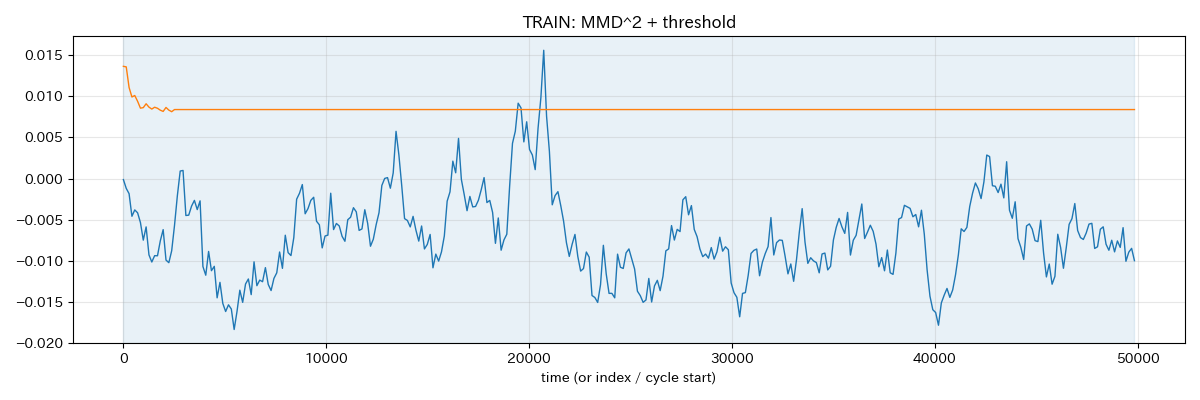

In [19]:
# ============================================================
# ⑧ train で動作確認（誤報っぽさを見る）：ユーザー設定
# ============================================================
TRAIN_CHECK_USE_HOLDOUT = False  # Trueなら x_ref に使った先頭 n_ref を除いて評価
USE_THRESHOLD = True            # 閾値線・is_drift を表示/集計する
MAX_STREAM_TRAIN = None         # 例: 20000（巨大データ対策）。制限しないなら None。

# 重要：元データのラベル列名（あなたの前工程の設定をそのまま使う想定）
# LABEL_COL = "__label__"  # 既に上で定義済みなら不要


# ============================================================
# ⑧ 実装：ストリーム実行ログ化（ログのラベル列名を label_key で統一）
# ============================================================
def run_stream(detector, X_stream, t_axis=None, y_axis=None, max_n=None, label_key="label") -> pd.DataFrame:
    """
    1サンプルずつ detector.predict(x_t) に流して、スコア/閾値/判定をログ化する。
    ログのラベル列名を label_key にする（例：label_key="__label__"）。
    """
    n = X_stream.shape[0]
    if max_n is not None:
        n = min(n, int(max_n))

    rec = []
    for i in range(n):
        x_t = X_stream[i]  # (D,)
        out = detector.predict(x_t, return_test_stat=True)
        d = out["data"]

        row = {
            "i": i,
            "t": float(t_axis[i]) if t_axis is not None else float(i),
            "mmd2": float(d.get("test_stat", np.nan)),
            "threshold": float(d.get("threshold", np.nan)),
            "is_drift": int(d.get("is_drift", 0)),
        }
        # ラベルがあるときだけ追加（列名は label_key）
        row[label_key] = (str(y_axis[i]) if y_axis is not None else None)

        rec.append(row)

    return pd.DataFrame(rec)


# ============================================================
# ⑧ 実装：ログ可視化（ラベル区間を背景色で塗る）
# ============================================================
def plot_mmd_log(df_log: pd.DataFrame, title: str, use_threshold: bool,
                 shade_labels: bool, label_key: str = "label"):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)

    # 背景色を見やすくするため、先に背景を塗る（線より下に回す）
    ax.set_axisbelow(True)

    if shade_labels and (label_key in df_log.columns) and df_log[label_key].notna().any():
        y = df_log[label_key].to_numpy()   # 文字/数値混在でも != はOK
        t = df_log["t"].to_numpy()

        change_idx = np.flatnonzero(y[1:] != y[:-1]) + 1
        bounds = np.r_[0, change_idx, len(y)]

        colors = plt.rcParams["axes.prop_cycle"].by_key().get(
            "color", ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
        )
        uniq = pd.unique(y)
        color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(uniq)}

        for k in range(len(bounds) - 1):
            a, b = bounds[k], bounds[k + 1]
            ax.axvspan(t[a], t[b - 1], alpha=0.10, color=color_map[y[a]], zorder=0)

    # スコアと閾値
    ax.plot(df_log["t"], df_log["mmd2"], linewidth=1.0, zorder=2)
    if use_threshold and ("threshold" in df_log.columns):
        ax.plot(df_log["t"], df_log["threshold"], linewidth=1.0, zorder=2)

    ax.set_title(title)
    ax.set_xlabel("time (or index / cycle start)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# ⑧ 実行：train を流して「誤報っぽさ」を見る
# ============================================================
# 参照に使った先頭 n_ref を除外して評価したいなら holdout を使う
use_holdout = TRAIN_CHECK_USE_HOLDOUT and (len(X_train_std) > n_ref)

X_train_check = X_train_std[n_ref:] if use_holdout else X_train_std
t_train_check = (t_train_s[n_ref:] if (t_train_s is not None and use_holdout) else t_train_s)
y_train_check = (y_train_s[n_ref:] if (y_train_s is not None and use_holdout) else y_train_s)

# ログ化（ログのラベル列名を LABEL_COL に合わせる）
df_log_train = run_stream(
    cd,
    X_train_check,
    t_axis=t_train_check,
    y_axis=y_train_check,
    max_n=MAX_STREAM_TRAIN,
    label_key=LABEL_COL  # ここがポイント：plot側と一致させる
)

# 集計（閾値ありの場合のみ）
if USE_THRESHOLD:
    ok_ratio = np.mean(df_log_train["mmd2"].values <= df_log_train["threshold"].values)
    fa_rate  = np.mean(df_log_train["is_drift"].values == 1)
    print(f"\n[TRAIN check] ratio(mmd2<=threshold)={ok_ratio:.3f}, false_alarm_rate={fa_rate:.3f}")

# 可視化（ラベルが無ければ自動で塗られない）
plot_mmd_log(
    df_log_train,
    title="TRAIN: MMD^2" + (" + threshold" if USE_THRESHOLD else ""),
    use_threshold=USE_THRESHOLD,
    shade_labels=True,
    label_key=LABEL_COL
)


## ⑨ テストデータ（test）で検知結果を確認する手順

目的：  
⑤で作った検知器 `cd` に test データを1サンプルずつ流し、
- MMD^2 スコア
- 閾値（threshold）
- ドリフト判定（is_drift）
をログ化・可視化して、異常（変化）区間でスコアが上がるかを確認する。

前提（このセルの前に用意されているもの）
- `cd`：`MMDDriftOnline(...)` で作った検知器
- `run_stream(...)`：⑥で定義した「ストリームログ化関数」
- `plot_mmd_log(...)`：⑥で定義した「スコア可視化関数」
- `X_test_std`：標準化済み test 配列 (N_test, D)
- `t_test_s`：各サンプルの時刻 (N_test,)（無ければ None でもOK）
- `y_test_s`：各サンプルのラベル (N_test,)（無ければ None でもOK）
- `USE_THRESHOLD`：閾値線を表示するか（⑥と同じ変数を使う想定）

---

### 使い方①：設定（ここだけ触ればよい）
- `SHADE_TEST_LABELS`
  - True：ラベルがある場合、区間ごとに背景色を塗って見やすくする
  - False：背景色は塗らない

- `MAX_STREAM_TEST`
  - None：全件流す
  - 数値：その件数だけ流す（巨大データ対策）



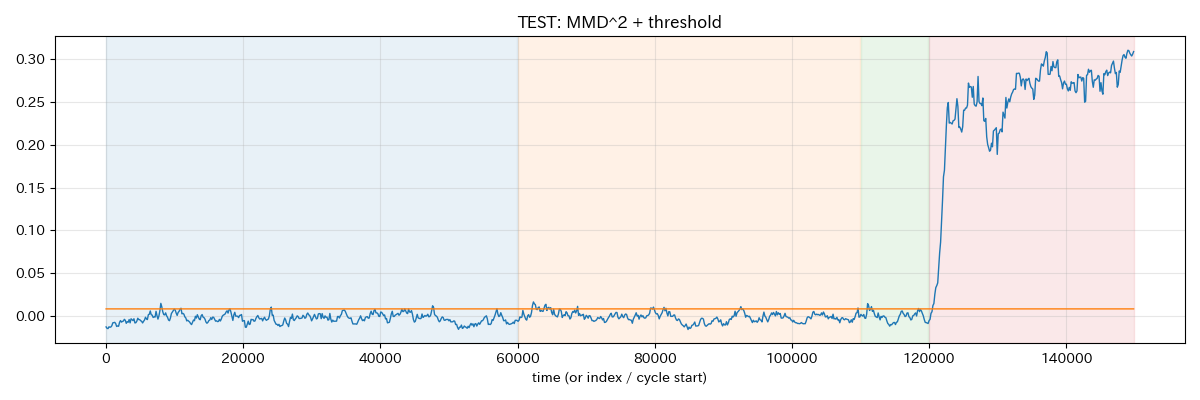


=== Mean MMD^2 by label (TEST) ===
segment
3    0.247520
2   -0.000343
1   -0.001068
0   -0.002770
Name: mmd2, dtype: float64


In [20]:
# ============================================================
# ⑨ テストデータで確認：ユーザー設定
# ============================================================
SHADE_TEST_LABELS = True
MAX_STREAM_TEST = None  # 例: 50000。制限しないなら None。


# ============================================================
# ⑨ 実装：test を流してログ化 → 可視化 → ラベル別要約
# ============================================================
# 注意：
# - 直前の改良版 run_stream は「ログのラベル列名を label_key で決める」仕様
# - plot_mmd_log も同じ label_key を参照するので、ここは LABEL_COL で統一する

df_log_test = run_stream(
    cd,
    X_test_std,
    t_axis=t_test_s,
    y_axis=y_test_s,
    max_n=MAX_STREAM_TEST,
    label_key=LABEL_COL  # ここがポイント：ログ列名を LABEL_COL にする
)

plot_mmd_log(
    df_log_test,
    title="TEST: MMD^2" + (" + threshold" if USE_THRESHOLD else ""),
    use_threshold=USE_THRESHOLD,
    shade_labels=SHADE_TEST_LABELS,
    label_key=LABEL_COL
)

# ラベルがある場合：ラベル別に平均スコア（mmd2）を要約
# （ラベル列名は LABEL_COL なので、それを使って groupby する）
if (LABEL_COL in df_log_test.columns) and df_log_test[LABEL_COL].notna().any():
    print("\n=== Mean MMD^2 by label (TEST) ===")
    print(
        df_log_test.dropna(subset=[LABEL_COL])
        .groupby(LABEL_COL)["mmd2"]
        .mean()
        .sort_values(ascending=False)
    )

# （任意）ログ保存したい場合
# from pathlib import Path
# OUT_DIR = Path(r".\out_mmd"); OUT_DIR.mkdir(parents=True, exist_ok=True)
# df_log_train.to_csv(OUT_DIR / "mmd_log_train.csv", index=False)
# df_log_test.to_csv(OUT_DIR / "mmd_log_test.csv", index=False)
# if period_summary is not None:
#     period_summary.to_csv(OUT_DIR / "period_summary.csv", index=False)
